In [1]:
%load_ext autoreload
%autoreload 2
CUDA_LAUNCH_BLOCKING=1

In [2]:
################Import Packages#######################
from __future__ import division, print_function
from typing import Dict, SupportsRound, Tuple, Any
from os import PathLike
from pathlib import Path
import matplotlib.pyplot as plt
import torch,gc
from torch.autograd import grad
from torch.autograd import Variable
import torch
import torch.nn as nn 
import torch.optim as optim
import torch.fft ############### Pytorch >= 1.8.0
import torch.nn.functional as F
from torch.utils.data import Dataset
import SimpleITK as sitk
import os, glob
import json
import subprocess
import sys
from PIL import Image
from torch.optim.lr_scheduler import CosineAnnealingLR,CosineAnnealingWarmRestarts,StepLR
from torch.utils.data import TensorDataset, DataLoader

import random
import yaml
from tqdm import tqdm, trange

from easydict import EasyDict as edict
import json
import cv2
import pickle

import numpy as np
from numpy import zeros, newaxis
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    dev = "cuda"
else:
    dev = "cpu"
    
torch.autograd.set_detect_anomaly(True)

In [3]:
################Parameter Loading#######################
def read_yaml(path):
    try:
        with open(path, 'r') as f:
            file = edict(yaml.load(f, Loader=yaml.FullLoader))
        return file
    except:
        print('NO FILE READ!')
        return None
    
para = read_yaml('./parameters.yml')

xDim = para.data.x 
yDim = para.data.y
zDim = para.data.z

def loss_Reg(y_pred):
        ### For 3D reg ###
        # dy = torch.abs(y_pred[:, :, 1:, :, :] - y_pred[:, :, :-1, :, :])
        # dx = torch.abs(y_pred[:, :, :, 1:, :] - y_pred[:, :, :, :-1, :])
        # dz = torch.abs(y_pred[:, :, :, :, 1:] - y_pred[:, :, :, :, :-1])
        # dy = dy * dy
        # dx = dx * dx
        # dz = dz * dz
        # d = torch.mean(dx) + torch.mean(dy) + torch.mean(dz)
        # grad = d / 3.0

        ### For 2D reg ###
        dy = torch.abs(y_pred[:, :, 1:, :] - y_pred[:, :, :-1, :])
        dx = torch.abs(y_pred[:, :, :, 1:] - y_pred[:, :, :, :-1])
        dy = dy * dy
        dx = dx * dx
        d = torch.mean(dx) + torch.mean(dy) 
        grad = d / 2.0
        
        return grad

In [4]:
# ##################Data Loading##########################
# readfilename = './2DShape/data' + '.json'
# datapath = './2DShape/'
# data = json.load(open(readfilename, 'r'))
# outputs = []
# keyword = 'train'
# # outputs = np.array(outputs)

# for i in trange (0,len(data[keyword])):
#     filename_src = datapath + data[keyword][i]['source']
#     itkimage_src = sitk.ReadImage(filename_src)
#     source_scan = sitk.GetArrayFromImage(itkimage_src)
#     source_scan = cv2.resize(source_scan, (128, 128))
#     source_scan = (source_scan - np.min(source_scan)) / (np.max(source_scan) - np.min(source_scan))
    
#     filename_tar = datapath + data[keyword][i]['target']
#     itkimage_tar = sitk.ReadImage(filename_tar)
#     target_scan = sitk.GetArrayFromImage(itkimage_tar)
#     target_scan = cv2.resize(target_scan, (128, 128))
#     target_scan = (target_scan - np.min(target_scan)) / (np.max(target_scan) - np.min(target_scan))
    
#     pair = np.concatenate((source_scan[newaxis,:], target_scan[newaxis,:]), axis=0)
#     outputs.append(pair)

# train = torch.FloatTensor(outputs)
# print (train.shape)

In [5]:
# with open('./2DShape.pkl', 'wb') as file:
#     pickle.dump(train, file)

# Load the NumPy array from the pickle file
with open('./2DShape.pkl', 'rb') as file:
    train = pickle.load(file)

In [6]:
'''Check initilization'''
#################Network optimization########################
from network import DiffeoDense
# from networks_vxm_gmvae import DiffeoDense

net = []
for i in range(3):
    temp = DiffeoDense(inshape = (xDim,yDim),
				 nb_unet_features= [[16, 32],[ 32, 32, 16, 16]],
                 nb_unet_conv_per_level=1,
                 int_steps=7,
                 int_downsize=2,
                 src_feats=1,
                 trg_feats=1,
                 unet_half_res= True)
    net.append(temp)
net = net[0].to(dev)

class TDataset(Dataset):
    def __init__(self, data, labels=None):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index]
        label = self.labels[index] if self.labels is not None else None
        return data, label
    
train_labels = json.load(open('./2DShape/data.json','r'))
train_set = TDataset(train, [d['label'] for d in train_labels['train']])
trainloader = torch.utils.data.DataLoader(train_set, batch_size = para.solver.batch_size, shuffle=True, num_workers=1)
sampleloader = torch.utils.data.DataLoader(train_set, batch_size = 1, shuffle=True, num_workers=1)

running_loss = 0 
running_loss_val = 0
template_loss = 0
printfreq = 1
sigma = 0.02
repara_trick = 0.0
loss_array = torch.FloatTensor(para.solver.epochs,1).fill_(0)
loss_array_val = torch.FloatTensor(para.solver.epochs,1).fill_(0)


if(para.model.loss == 'L2'):
    criterion = nn.MSELoss()
elif (para.model.loss == 'L1'):
    criterion = nn.L1Loss()
if(para.model.optimizer == 'Adam'):
    optimizer = optim.Adam(net.parameters(), lr= para.solver.lr)
elif (para.model.optimizer == 'SGD'):
    optimizer = optim.SGD(net.parameters(), lr= para.solver.lr, momentum=0.9)
if (para.model.scheduler == 'CosAn'):
    scheduler = CosineAnnealingLR(optimizer, T_max=len(trainloader), eta_min=0)

optimizer_template = optim.Adam(net.parameters(), lr= para.solver.lr)
scheduler_template = CosineAnnealingLR(optimizer_template, T_max=len(trainloader), eta_min=0)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3491.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
########### Augmentation Training ###########

total_loss = []
gmvae_total_loss = []

for epoch in trange(para.solver.epochs): 
    total= 0; 
    gmvae_loss = 0
    total_val = 0; 
    total_template = 0; 
    mse_loss = 0
    reg_loss = 0
    latent_f = []
    net.train()
    all_labels = []
    count = 0
    
    for j, image_data in enumerate(trainloader):
        inputs, batch_labels = image_data
        inputs = inputs.to(dev)
        b, c, w, h = inputs.shape
        src_bch = inputs[:,0,...].reshape(b,1,w,h)
        tar_bch = inputs[:,1,...].reshape(b,1,w,h)
        
        optimizer.zero_grad()
        pred = net(src_bch, tar_bch, registration = True)     
        loss = criterion(pred[0], tar_bch) 
        loss2 = loss_Reg(pred[1])
        # loss_total = loss + para.solver.alpha * loss2 
        loss_total = loss + para.solver.alpha * loss2 + para.solver.beta * pred[3]
        loss_total.backward(retain_graph=True)
        optimizer.step()
        
        running_loss += loss_total.item()
        total += running_loss
        gmvae_loss += pred[3].item()
        running_loss = 0.0
        count += 1
    
    total_loss.append(total/count)
    gmvae_total_loss.append(gmvae_loss/count)

100%|██████████| 500/500 [10:38<00:00,  1.28s/it]


In [9]:
PATH = './pre_trained_models/MGAug_2DShape_final.pth'
torch.save(net, PATH)

In [10]:
def detJac(np_displacement_field):
    
    np_displacement_field = np_displacement_field.permute(2, 3, 1, 0).squeeze()
    sitk_displacement_field = sitk.GetImageFromArray(np_displacement_field, isVector=True)
    jacobian_det_volume = sitk.DisplacementFieldJacobianDeterminant(sitk_displacement_field)
    jacobian_det_np_arr = sitk.GetArrayViewFromImage(jacobian_det_volume)
    
    return jacobian_det_np_arr

def save_img(src, tar, deform, field, count):
    
    src = src.squeeze().detach().cpu()
    tar = tar.squeeze().detach().cpu()
    deform = deform.squeeze().detach().cpu()
    field = field.detach().cpu()
    
    np_displacement_field = field.permute(2, 3, 1, 0).squeeze()
    sitk_displacement_field = sitk.GetImageFromArray(np_displacement_field, isVector=True)
    jacobian_det_volume = sitk.DisplacementFieldJacobianDeterminant(sitk_displacement_field)
    jacobian_det_np_arr = sitk.GetArrayViewFromImage(jacobian_det_volume)
    
    src_img = sitk.GetImageFromArray(src)
    tar_img = sitk.GetImageFromArray(tar)
    def_img = sitk.GetImageFromArray(deform)
    detjac = sitk.GetImageFromArray(jacobian_det_np_arr)
    
    sitk.WriteImage(src_img, f'./save_img/src/src{count}.nii')
    sitk.WriteImage(tar_img, f'./save_img/tar/tar{count}.nii')
    sitk.WriteImage(def_img, f'./save_img/def/def{count}.nii')
    sitk.WriteImage(detjac, f'./save_img/detJac/dj{count}.nii')

def plot(src, tar, deform, field, count):
    
    src = src.squeeze().detach().cpu()
    tar = tar.squeeze().detach().cpu()
    deform = deform.squeeze().detach().cpu()
    field = field.detach().cpu()
    
    np_displacement_field = field.permute(2, 3, 1, 0).squeeze()
    sitk_displacement_field = sitk.GetImageFromArray(np_displacement_field, isVector=True)
    jacobian_det_volume = sitk.DisplacementFieldJacobianDeterminant(sitk_displacement_field)
    jacobian_det_np_arr = sitk.GetArrayViewFromImage(jacobian_det_volume)
    
    # dj = detJac(field)
    
    # fig, axs = plt.subplots(1, 4, figsize=(8, 2))
    fig, axs = plt.subplots(1, 4, figsize=(6, 1.5), gridspec_kw={'width_ratios': [1, 1, 1, 1.5]})


    axs[0].imshow(src, cmap='gray', aspect='auto')
    axs[0].axis('tight')
    axs[0].axis('off')  
    # axs[0].set_title('Src')
    
    axs[1].imshow(tar, cmap='gray', aspect='auto')
    axs[1].axis('tight')
    axs[1].axis('off')  
    # axs[1].set_title('Tar')
    
    axs[2].imshow(deform, cmap='gray', aspect='auto')
    axs[2].axis('tight')
    axs[2].axis('off')  
    # axs[2].set_title('Deform')
    
    gs = axs[3].get_gridspec()
    image_plot = axs[3].imshow(jacobian_det_np_arr, cmap='YlGnBu', vmin=jacobian_det_np_arr.min(), vmax=jacobian_det_np_arr.max())
    axs[3].axis('off')
    colorbar = fig.colorbar(image_plot, ax=axs[3])
    colorbar.ax.tick_params(labelsize=6)
    colorbar.ax.locator_params(nbins=4) 
    plt.subplots_adjust(wspace=0)
    
    # plt.savefig(f"./figures/vxm/vxm_tr_qdb_ts_mnist/vxm_{count:03d}.png", bbox_inches='tight')
    
    plt.show()

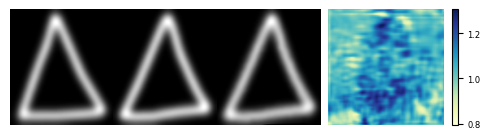

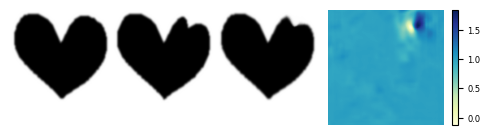

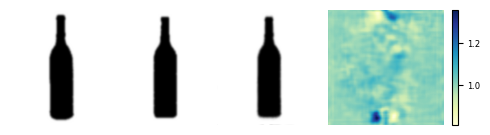

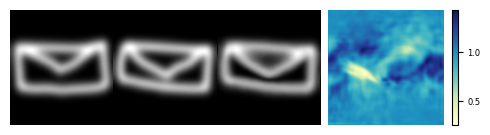

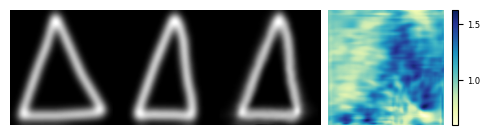

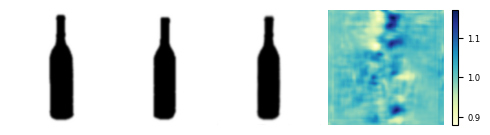

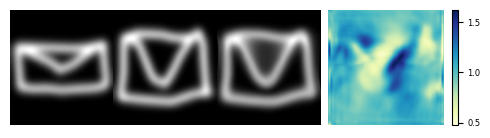

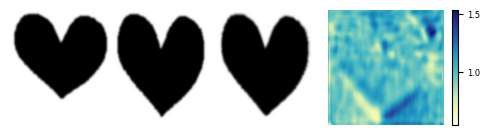

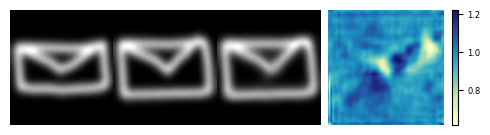

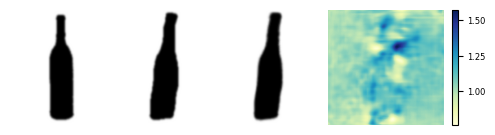

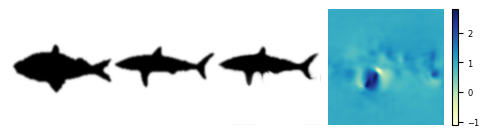

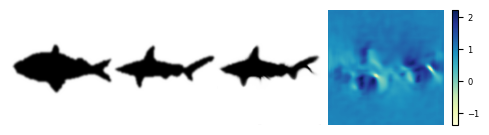

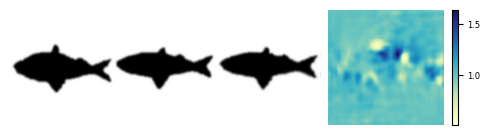

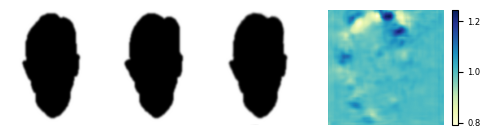

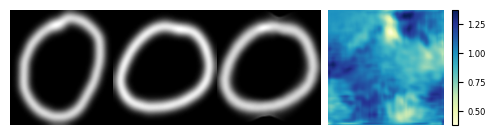

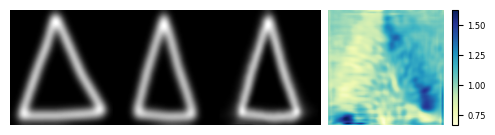

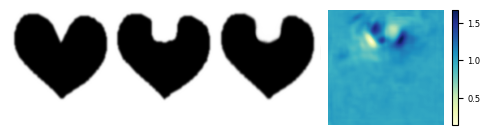

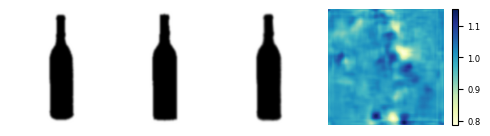

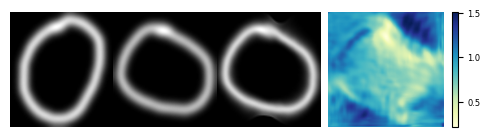

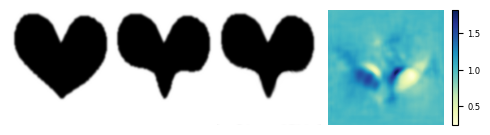

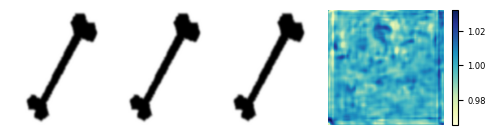

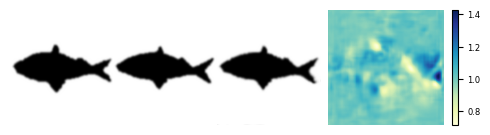

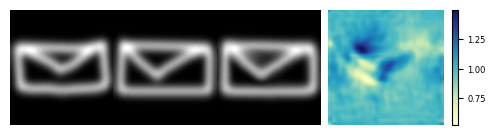

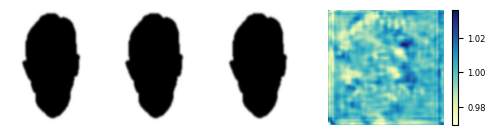

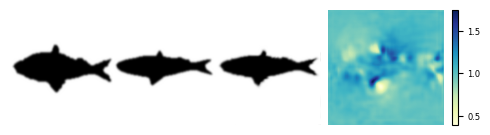

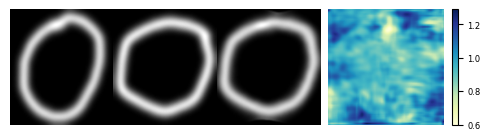

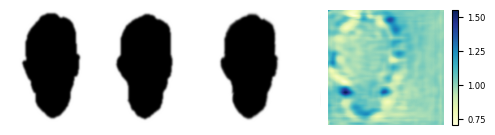

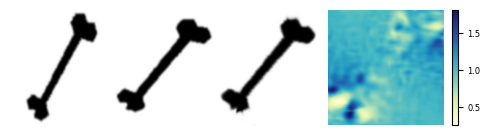

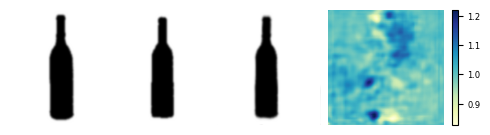

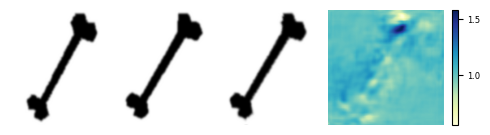

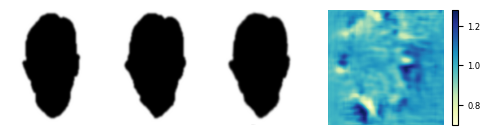

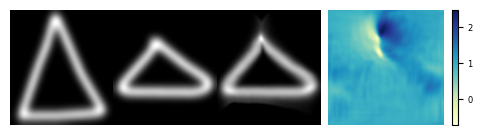

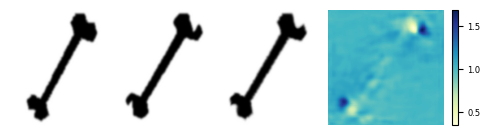

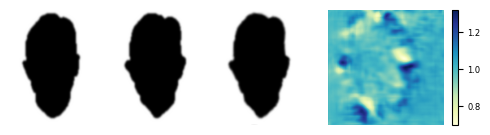

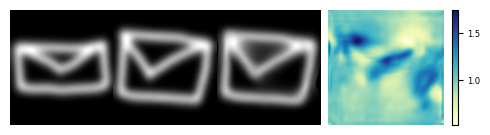

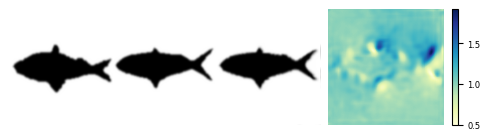

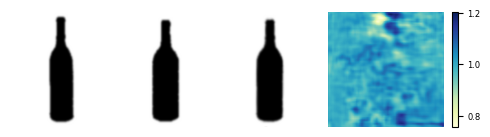

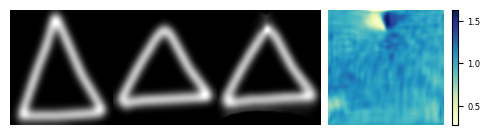

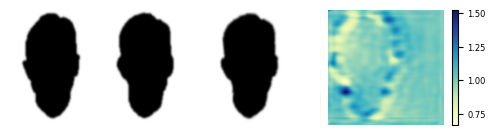

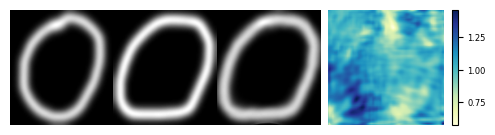

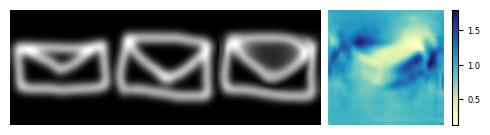

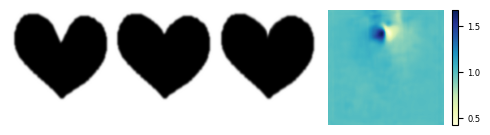

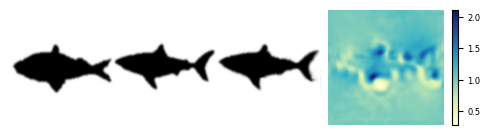

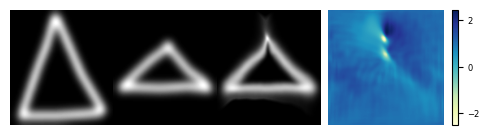

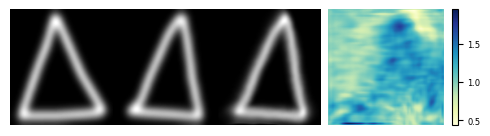

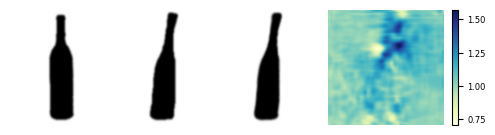

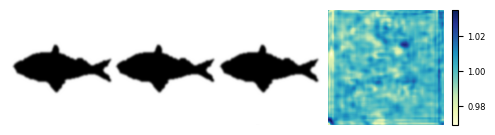

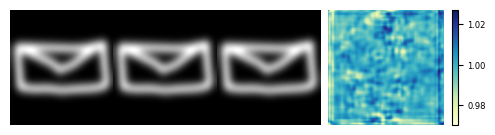

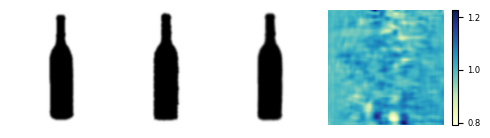

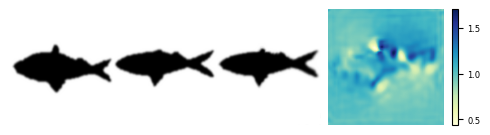

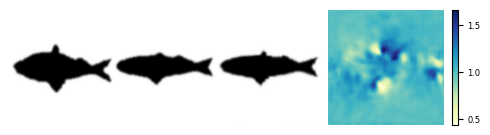

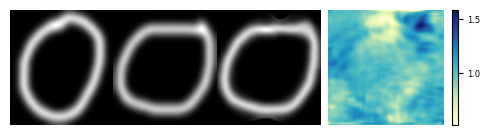

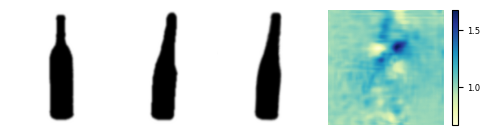

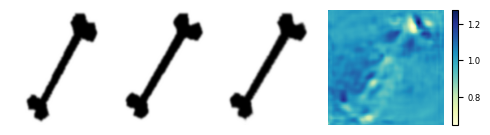

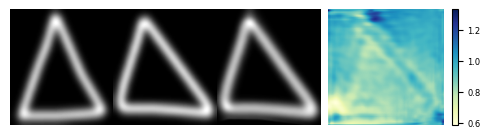

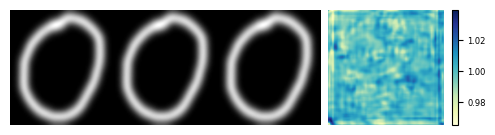

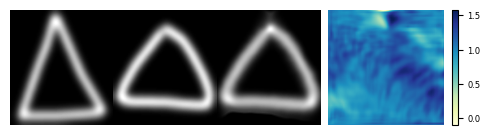

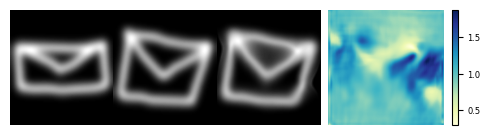

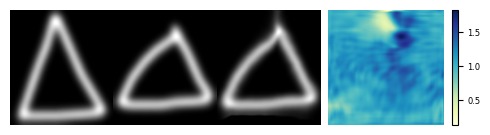

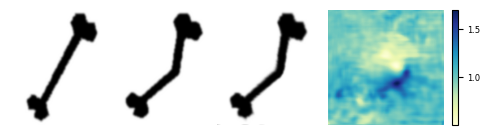

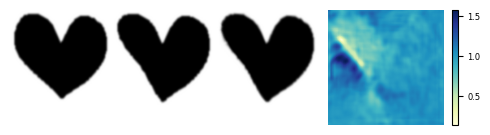

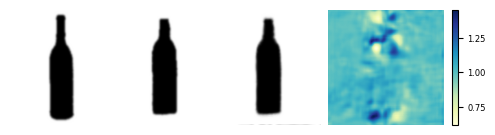

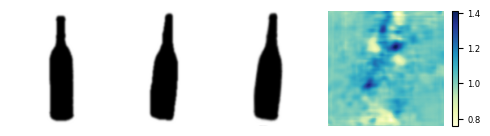

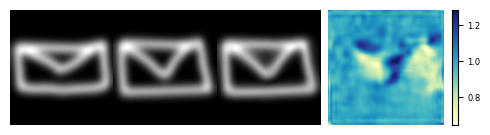

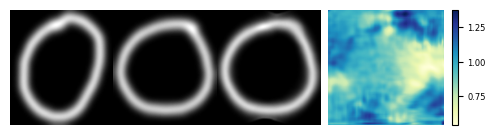

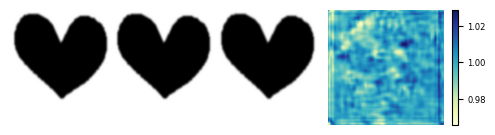

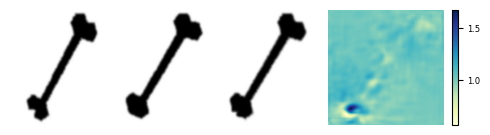

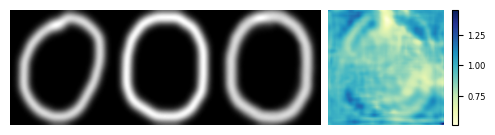

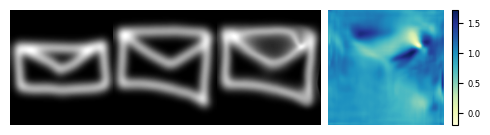

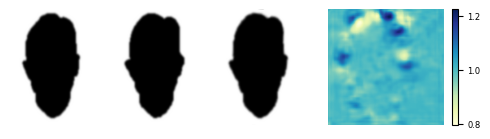

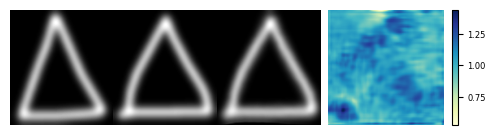

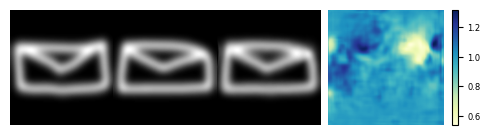

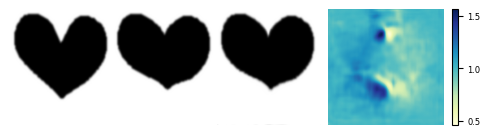

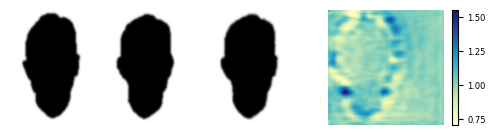

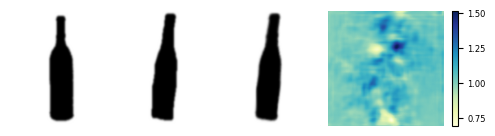

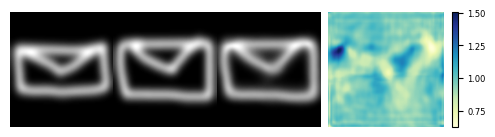

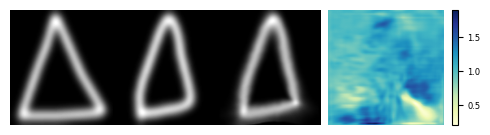

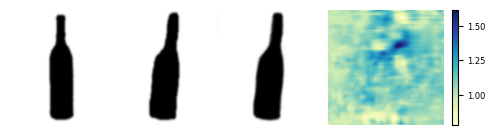

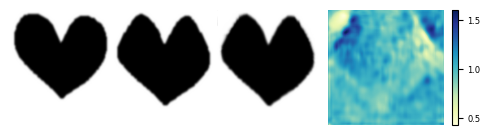

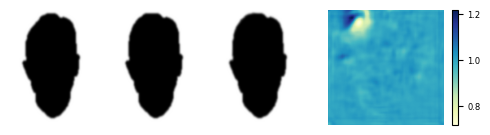

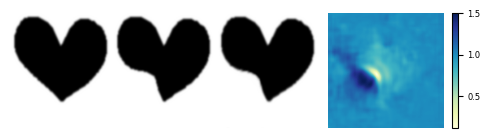

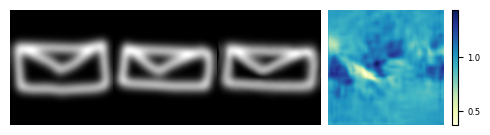

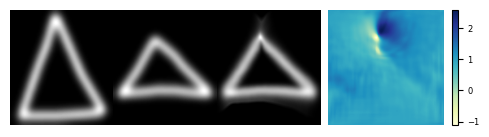

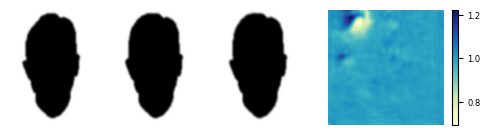

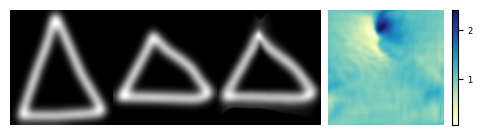

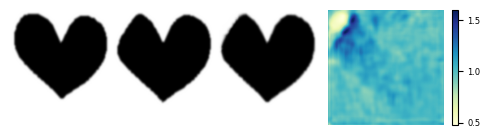

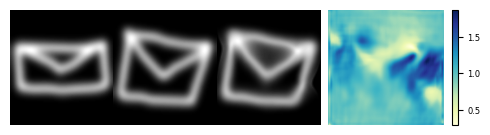

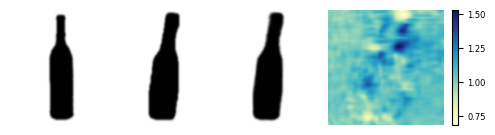

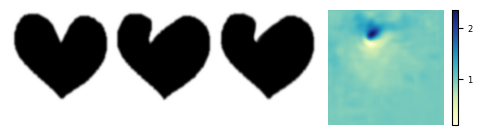

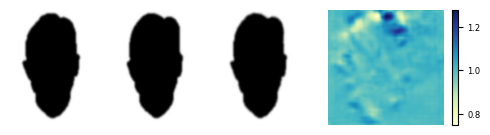

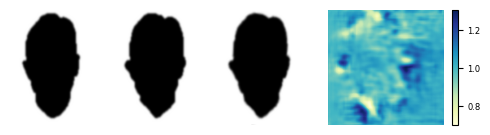

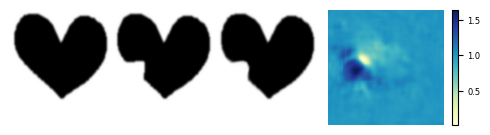

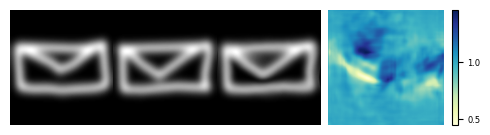

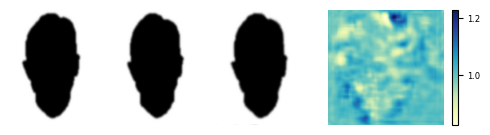

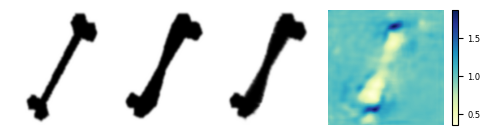

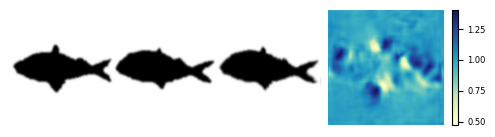

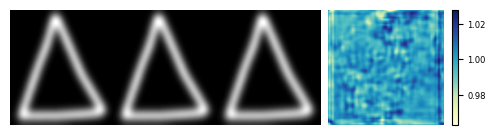

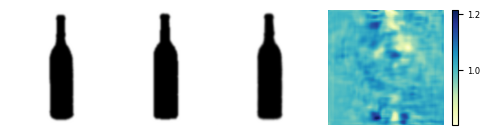

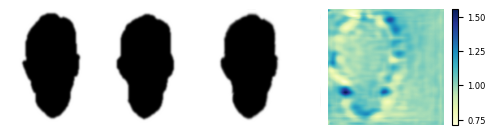

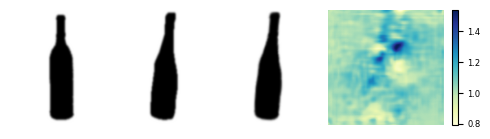

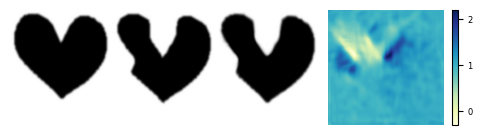

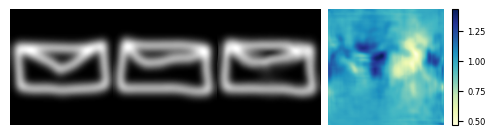

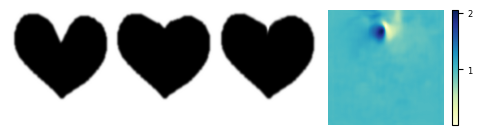

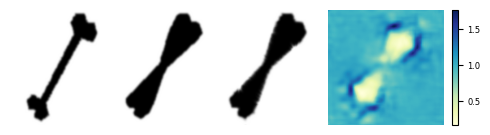

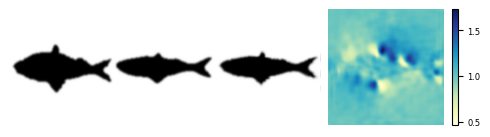

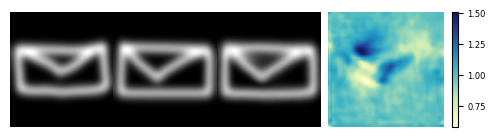

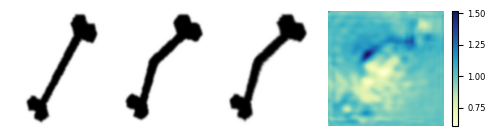

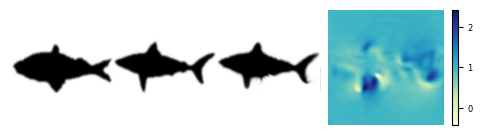

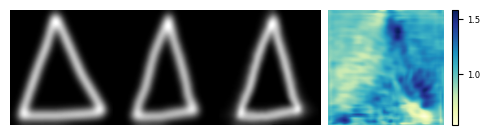

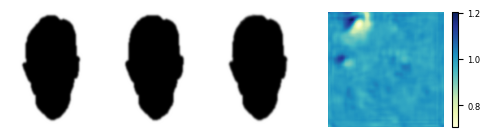

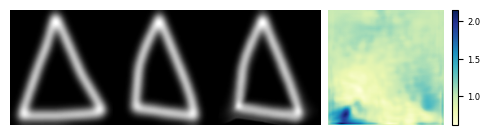

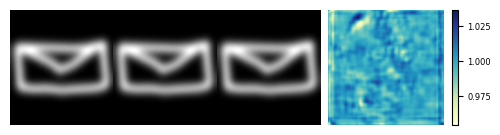

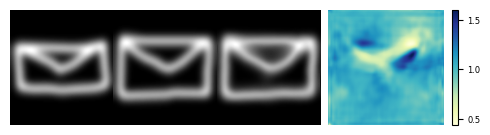

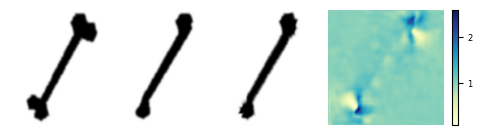

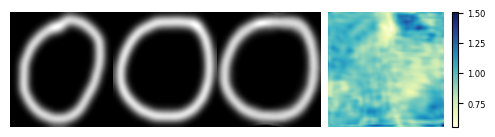

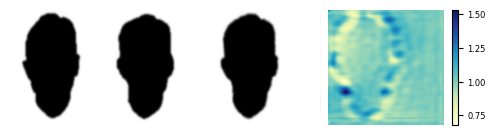

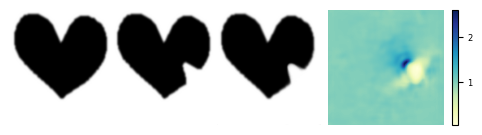

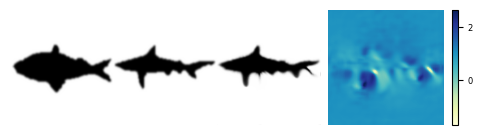

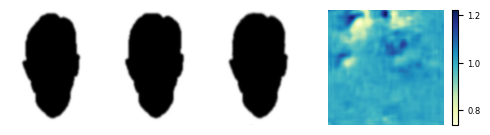

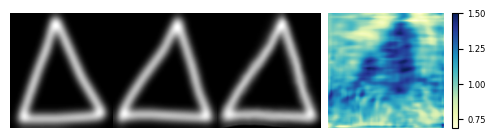

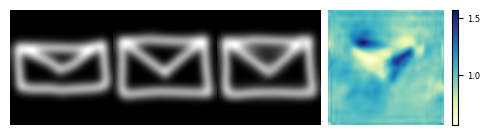

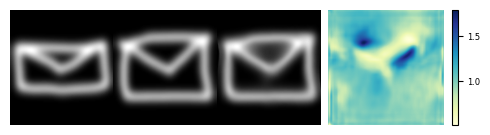

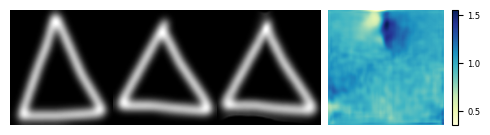

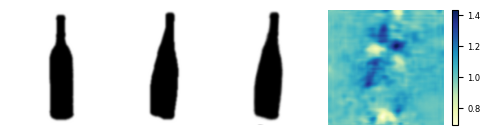

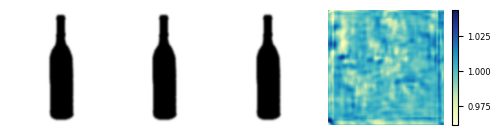

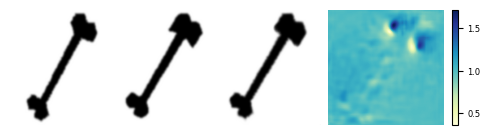

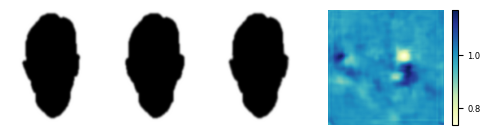

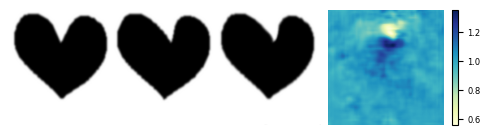

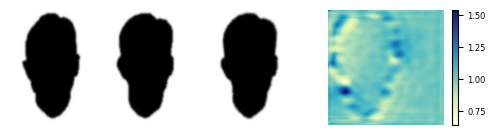

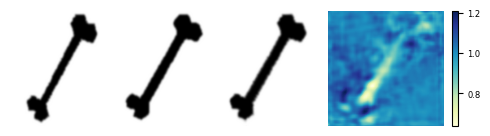

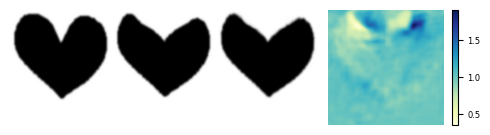

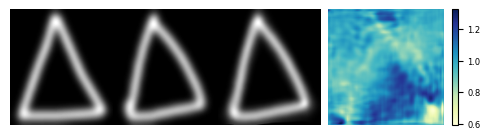

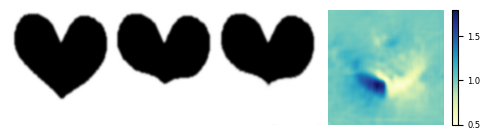

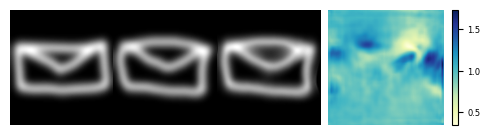

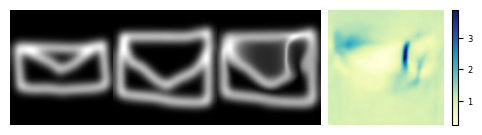

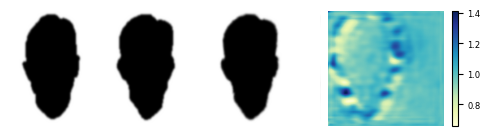

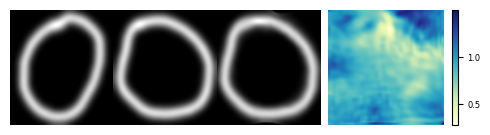

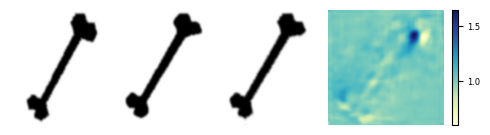

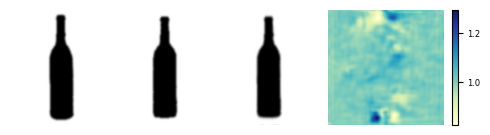

In [11]:
PATH = './pre_trained_models/MGAug_2DShape_final.pth'
torch.save(net, PATH)
net.eval()

count = 0
with torch.no_grad():
    for j, image_data in enumerate(sampleloader):
        inputs, batch_labels = image_data
        inputs = inputs.to(dev)
        b, c, w, h = inputs.shape
        src_bch = inputs[:,0,...].reshape(b,1,w,h)
        tar_bch = inputs[:,1,...].reshape(b,1,w,h)
        # print(src_bch.shape, tar_bch.shape)
        pred = net(src_bch, tar_bch, registration = True)   
        
        plot(src_bch, tar_bch, pred[0], pred[1], count)
        save_img(src_bch, tar_bch, pred[0], pred[1], count)
        
#         jacobian_array = pred[1].detach().cpu().squeeze()
        
#         magnitude_array = np.linalg.norm(jacobian_array, axis=0)

#         # Count the number of voxels with magnitude less than or equal to zero
#         num_voxels_zero_or_less = np.sum(magnitude_array <= 0)

#         # Print the result
#         print(f"Number of voxels with magnitude <= 0: {num_voxels_zero_or_less}")
        
        count += 1
        
#         if count == 2:
#             break